In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce


##### Create a csv with all neuron metrics

In [3]:
gpt2_projections = pd.read_csv('./gpt2_neuron_projections.csv')
dpo_projections = pd.read_csv('./dpo_neuron_projections.csv')

gpt2_activations = pd.read_csv('./gpt2_neuron_activations.csv')
dpo_activations = pd.read_csv('./dpo_neuron_activations.csv')

gpt2_cossims = pd.read_csv('./gpt2_neuron_cossims.csv')
dpo_cossims = pd.read_csv('./dpo_neuron_cossims.csv')

# gpt2_value_vector_projs = pd.read_csv('./gpt2_value_vector_projections.csv')
# dpo_value_vector_projs = pd.read_csv('./dpo_value_vector_projections.csv')

FileNotFoundError: [Errno 2] No such file or directory: './gpt2_neuron_projections.csv'

In [4]:
# List of DataFrames to merge
dfs = [gpt2_projections, dpo_projections, gpt2_activations, dpo_activations, gpt2_cossims, dpo_cossims]

# Merge all DataFrames in the list on 'layer_idx' and 'neuron_idx'
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['layer_idx', 'neuron_idx']), dfs)

merged_df['gpt2_value_vector_projs'] = merged_df['gpt2_projection'] / merged_df['gpt2_activation']
merged_df['dpo_value_vector_projs'] = merged_df['dpo_projection'] / merged_df['dpo_activation']

merged_df['projection_diff'] = merged_df['gpt2_projection'] - merged_df['dpo_projection']
merged_df['activation_diff'] = merged_df['gpt2_activation'] - merged_df['dpo_activation']

# Rank only rows with positive gpt2_activation
# First, create a mask for positive gpt2_activation
# positive_mask = merged_df['gpt2_activation'] > 0

# # Then, rank only those rows, and assign NaN for others
# merged_df['cossim_rank'] = pd.Series(dtype=float)  # Initialize the rank column with NaN
# merged_df.loc[positive_mask, 'cossim_rank'] = merged_df.loc[positive_mask, 'cosine_similarity'].rank(ascending=False, method='min').astype(int)

# Display the first few rows of the DataFrame
print(merged_df.head())

NameError: name 'gpt2_projections' is not defined

In [15]:
print(len(merged_df))

98304


In [16]:
merged_df.to_csv('all_neuron_metrics.csv', index=False)

##### Add neuron group column and ranks of projection difference from each group

In [2]:
merged_df = pd.read_csv('./all_neuron_metrics.csv')

In [4]:
# Define conditions for each neuron group and their corresponding group labels
conditions = {
    'TP-': (merged_df['gpt2_cossim'] > 0) & 
          (merged_df['gpt2_activation'] >= 0) & 
          (merged_df['activation_diff'] > 0),
    
    'TN+': (merged_df['gpt2_cossim'] > 0) & 
          (merged_df['gpt2_activation'] < 0) & 
          (merged_df['activation_diff'] > 0),
    
    'AP+': (merged_df['gpt2_cossim'] < 0) & 
          (merged_df['gpt2_activation'] >= 0) & 
          (merged_df['activation_diff'] < 0),
    
    'AN-': (merged_df['gpt2_cossim'] < 0) & 
          (merged_df['gpt2_activation'] < 0) & 
          (merged_df['activation_diff'] < 0)
}

# Create a new column 'neuron_group' and assign group labels based on toxicity-reducing conditions
merged_df['neuron_group'] = None

# Assign the group labels to the appropriate rows based on the conditions
for group, condition in conditions.items():
    merged_df.loc[condition, 'neuron_group'] = group

# Display the first few rows to verify
print(merged_df.head())


   layer_idx  neuron_idx  gpt2_projection  dpo_projection  gpt2_activation  \
0          0           0        -0.004434       -0.004821        -0.086628   
1          0           1         0.000381        0.000381        -0.010077   
2          0           2         0.008536        0.008656        -0.065236   
3          0           3         0.004260        0.004129        -0.081713   
4          0           4         0.000003       -0.000003        -0.073461   

   dpo_activation  gpt2_cossim  dpo_cossim  gpt2_value_vector_projs  \
0       -0.094152     0.020808    0.020818                 0.051181   
1       -0.010096    -0.015356   -0.015325                -0.037849   
2       -0.066241    -0.044885   -0.044824                -0.130852   
3       -0.079245    -0.015817   -0.015809                -0.052139   
4       -0.079985    -0.000018    0.000015                -0.000046   

   dpo_value_vector_projs  projection_diff  activation_diff  \
0                0.051206     3.874512e-0

In [24]:
def get_top_neurons(merged_df, group_name, num_of_neurons):
    """
    Return a list of tuples (layer_idx, neuron_idx, dpo_activation) for the top 100 neurons in the 'TP-' group
    with the largest 'projection_difference' value.
    """
    # Filter the dataframe for the 'TP-' group
    neuron_group = merged_df[merged_df['neuron_group'] == group_name]

    # Sort the filtered dataframe by 'projection_difference' in descending order
    neuron_group_sorted = neuron_group.sort_values(by='projection_diff', ascending=False)

    # Select the top e.g. 1000 rows
    top_neurons = neuron_group_sorted.head(num_of_neurons)

    # Extract the relevant columns and convert to a list of tuples
    top_neurons_list = list(top_neurons[['layer_idx', 'neuron_idx', 'dpo_pregelu_activation']].itertuples(index=False, name=None))

    return top_neurons_list

# Example usage
top_neurons_list = get_top_neurons(merged_df, 'AP+', 1803)
print(top_neurons_list)



[(20, 2820, 4.528498885341144), (21, 3336, 4.493504837409559), (23, 4039, 0.8211284939194866), (23, 816, 3.013083120193776), (18, 919, 2.7401889591580724), (21, 3929, 1.341262194818894), (19, 2191, 1.2059835577819285), (20, 474, 0.6990417479447519), (17, 2875, 0.8321183563650939), (22, 3559, 0.7115135749479111), (22, 3980, 3.455534103350405), (23, 1268, 0.2287940376192729), (22, 2308, 2.0707749153104382), (23, 1274, 0.1164660985999288), (21, 2976, 0.5110337680908288), (19, 189, 0.3021938813195777), (21, 2469, 0.3752717674860735), (23, 2656, 0.5055638941210504), (23, 2145, 0.3247978975521743), (23, 712, 0.6728378692054849), (23, 256, 0.9405629957248888), (16, 140, 4.192470921264023), (23, 1826, 0.7661252467068517), (22, 1869, 0.4040995571512019), (21, 3379, 0.2221884314230278), (23, 488, 0.252761506444069), (13, 3042, 3.175409827591212), (23, 1388, 0.2281746109905325), (19, 1082, 2.48282957271938), (21, 1686, 0.7418164266174362), (17, 1130, 0.2027619315422101), (9, 1584, 1.1640498183712

##### Inspect distribution of cossine similarities

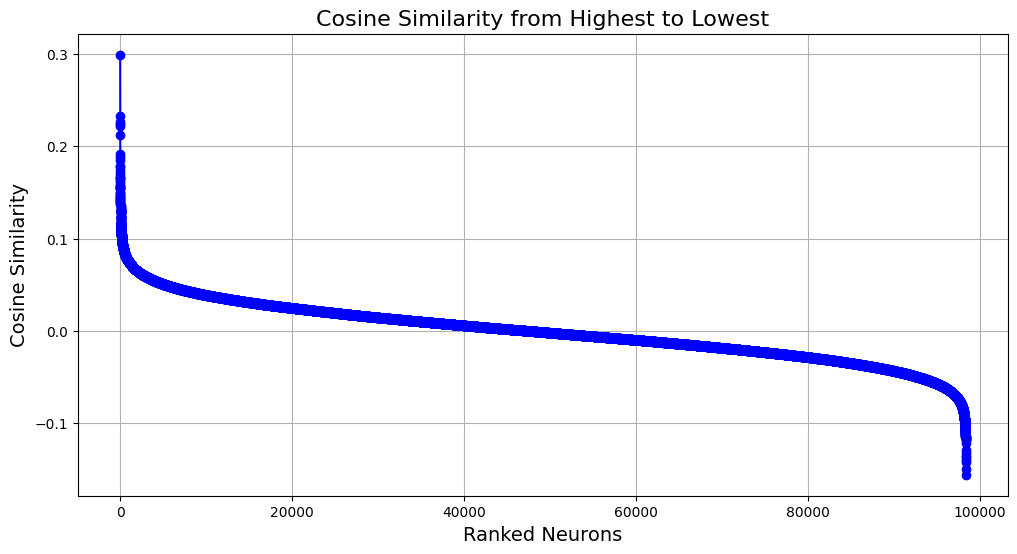

In [12]:
# Step 1: Sort merged_df by cosine_similarity in descending order
sorted_df = merged_df.sort_values(by='cosine_similarity', ascending=False)

# Step 2: Plot the sorted cosine similarity values
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(sorted_df) + 1), sorted_df['cosine_similarity'].values, marker='o', linestyle='-', color='blue')
plt.title('Cosine Similarity from Highest to Lowest', fontsize=16)
plt.xlabel('Ranked Neurons', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.grid(True)
plt.show()

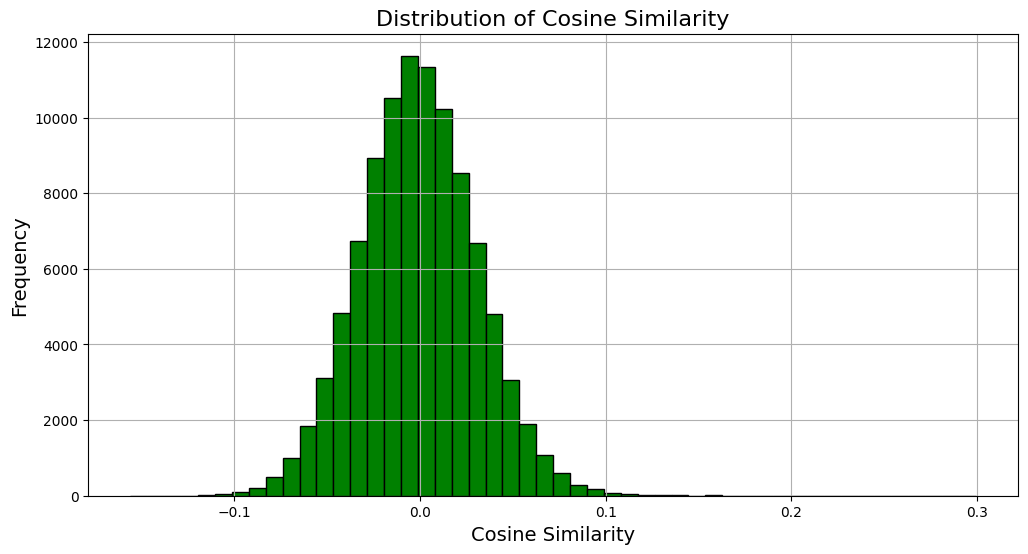

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(merged_df['cosine_similarity'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Cosine Similarity', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

##### Inspect distribution of activations

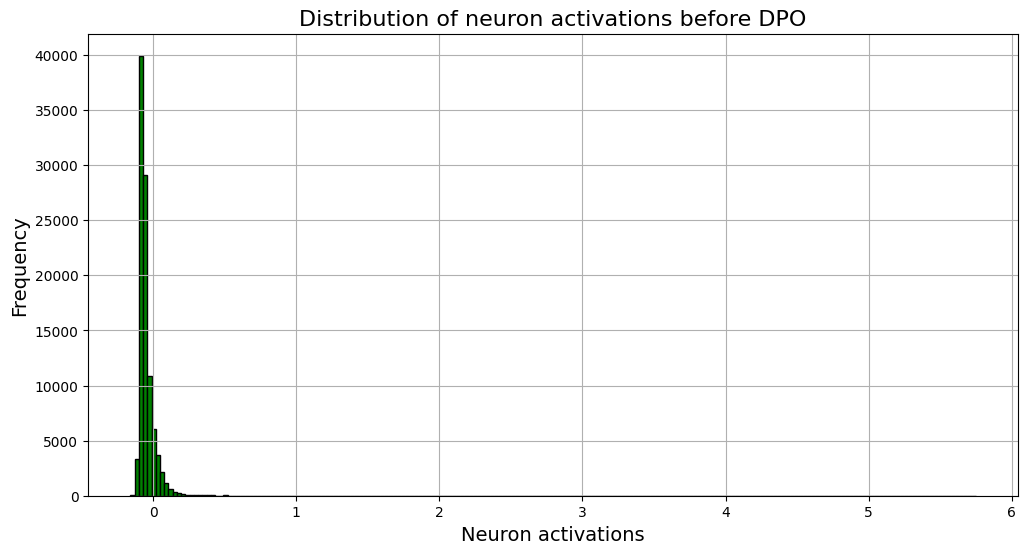

In [5]:
# Most neurons are not activated (with negative activations due to GELU)
plt.figure(figsize=(12, 6))
plt.hist(merged_df['gpt2_activation'], bins=200, color='green', edgecolor='black')
plt.title('Distribution of neuron activations before DPO', fontsize=16)
plt.xlabel('Neuron activations', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

##### Plot the cumulative sum of projection differences

In [3]:
merged_df = pd.read_csv('./all_neuron_metrics.csv')

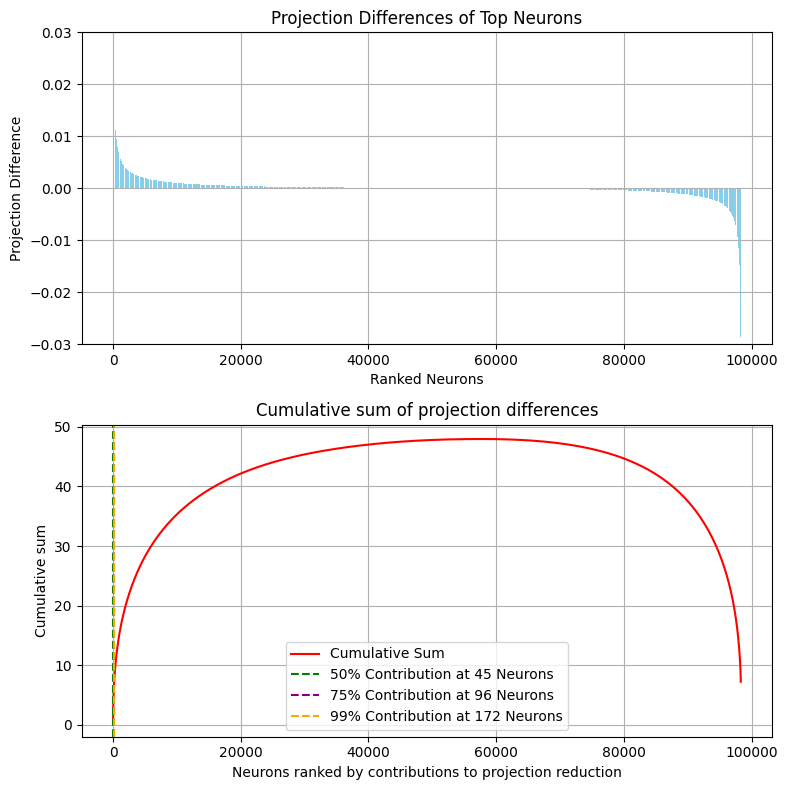

In [17]:
# Step 1: Sort all neurons by projection difference in descending order
all_projection_diffs = sorted(merged_df['projection_diff'].values, reverse=True)

# Step 2: Calculate the total sum of all projection differences
total_sum = np.sum(all_projection_diffs)

# Step 3: Compute the cumulative sum of the sorted projection differences
cumulative_sum = np.cumsum(all_projection_diffs)

# Step 4: Determine the 50%, 75%, and 99% thresholds
half_threshold = total_sum * 0.5
seventyfive_threshold = total_sum * 0.75
ninety_nine_threshold = total_sum * 0.99

# Find the indexes where the cumulative sum reaches 50%, 75%, and 99%
half_index = np.argmax(cumulative_sum >= half_threshold)
seventyfive_index = np.argmax(cumulative_sum >= seventyfive_threshold)
ninety_nine_index = np.argmax(cumulative_sum >= ninety_nine_threshold)

# Step 5: Limit the number of neurons to plot on the x-axis to 1000
plot_limit = min(len(all_projection_diffs), 100000)

# Step 6: Create subplots
fig, ax1 = plt.subplots(2, 1, figsize=(8, 8))

# Plot 1: Projection Differences
ax1[0].bar(range(1, plot_limit + 1), all_projection_diffs[:plot_limit], color='skyblue')
ax1[0].set_title('Projection Differences of Top Neurons')
ax1[0].set_xlabel('Ranked Neurons')
ax1[0].set_ylabel('Projection Difference')
ax1[0].set_ylim(-0.03, 0.03)  # Rescale y-axis
ax1[0].grid(True)

# Plot 2: Cumulative Sum
ax1[1].plot(range(1, plot_limit + 1), cumulative_sum[:plot_limit], color='red', label='Cumulative Sum')
ax1[1].axvline(x=min(half_index + 1, plot_limit), color='green', linestyle='--', label=f'50% Contribution at {half_index+1} Neurons')
ax1[1].axvline(x=min(seventyfive_index + 1, plot_limit), color='purple', linestyle='--', label=f'75% Contribution at {seventyfive_index+1} Neurons')
ax1[1].axvline(x=min(ninety_nine_index + 1, plot_limit), color='orange', linestyle='--', label=f'99% Contribution at {ninety_nine_index+1} Neurons')
ax1[1].set_title('Cumulative sum of projection differences', fontsize = 12)
ax1[1].set_xlabel('Neurons ranked by contributions to projection reduction', fontsize = 10)
ax1[1].set_ylabel('Cumulative sum', fontsize = 10)
ax1[1].legend()
ax1[1].grid(True)

plt.tight_layout()
plt.show()

##### Plot the top 172 neuron's cossims and activation change

In [4]:
# Step 1: Rank rows by highest to lowest projection_diff
# merged_df = pd.read_csv('./all_neuron_metrics.csv')
ranked_df = merged_df.sort_values(by='projection_diff', ascending=False).head(1720)

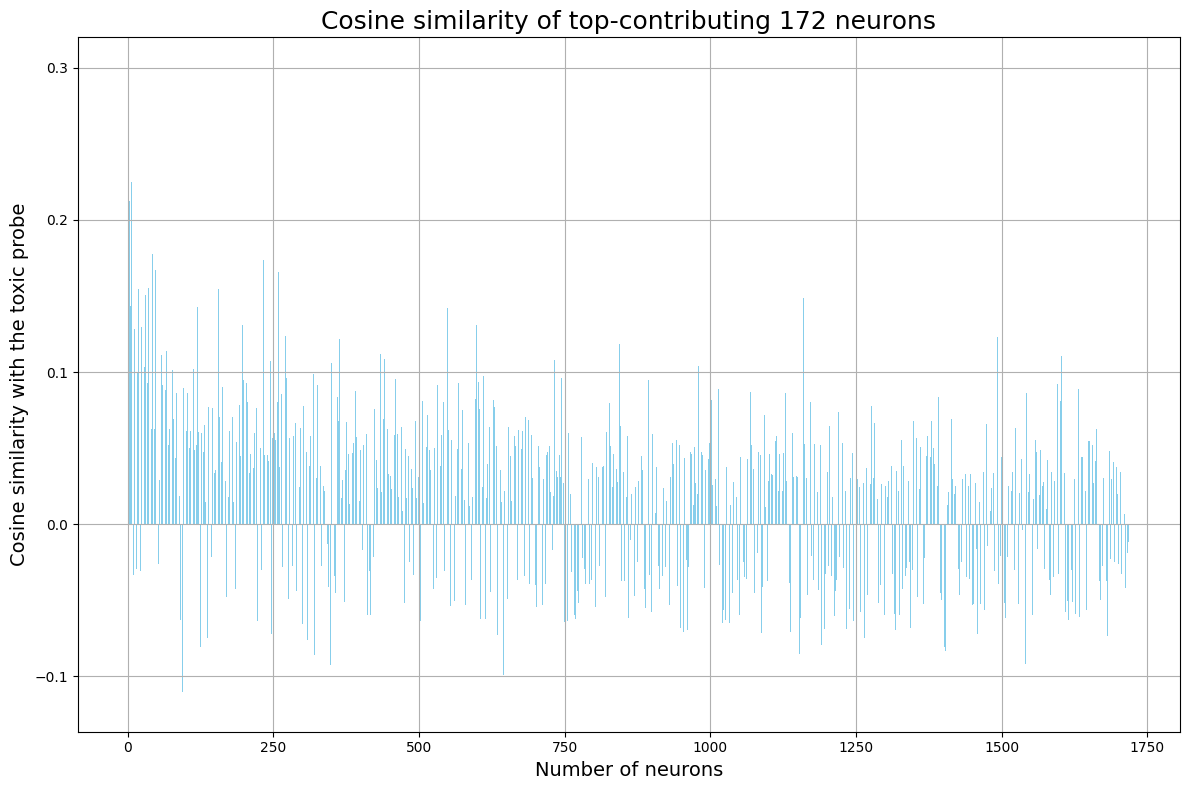

In [6]:
# Step 1: Plot the cosine similarity values in a bar chart with narrower bars
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.bar(range(1, 1721), ranked_df['cosine_similarity'], color='skyblue', width=0.6)

# # Step 2: Annotate every other bar with its corresponding rank
# for i, bar in enumerate(bars):
#     if i % 1 == 0:  # Annotate every other bar
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 if yval > 0 else yval - 0.01, 
#                  f'{ranked_df["cossim_rank"].iloc[i]}', 
#                  ha='center', va='bottom' if yval > 0 else 'top', fontsize=10)

# Step 3: Customize the chart
plt.title('Cosine similarity of top-contributing 172 neurons', fontsize=18)
plt.xlabel('Number of neurons', fontsize=14)
plt.ylabel('Cosine similarity with the toxic probe', fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjusts the layout to prevent clipping of labels
plt.show()

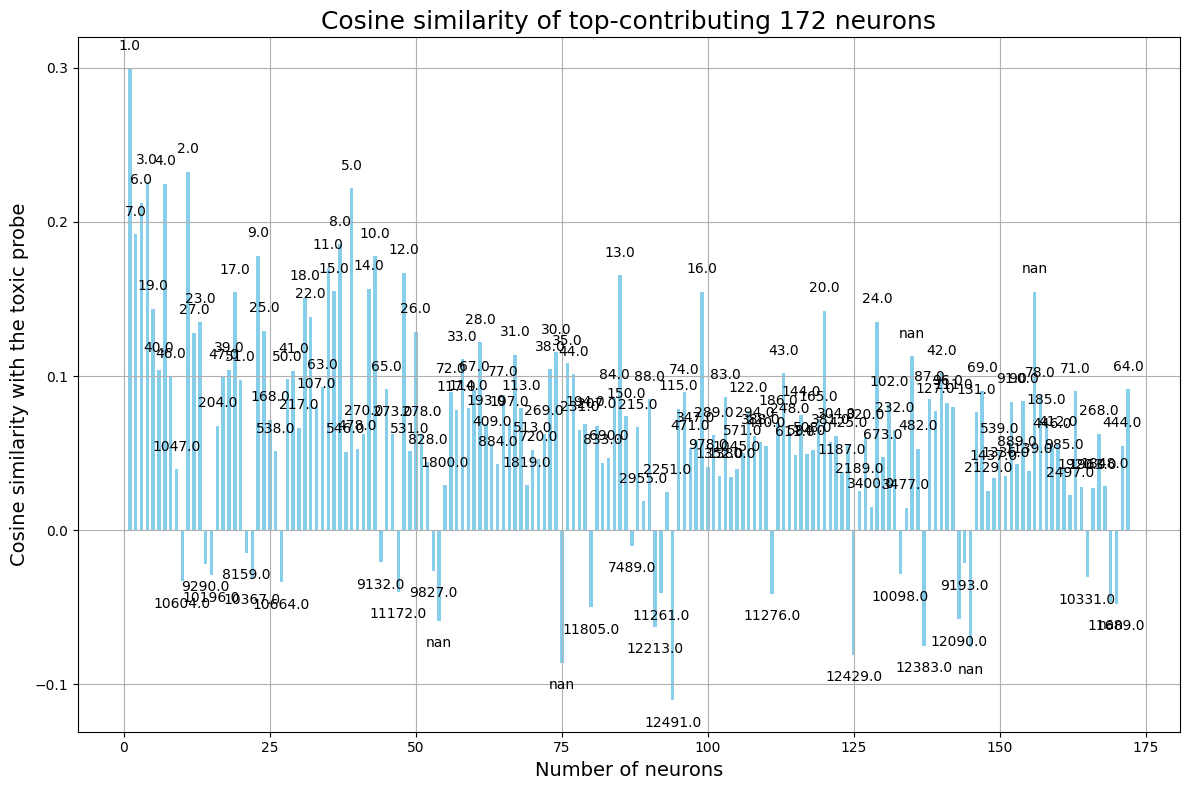

In [5]:
# Step 1: Plot the cosine similarity values in a bar chart with narrower bars
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.bar(range(1, 173), ranked_df['cosine_similarity'], color='skyblue', width=0.6)

# Step 2: Annotate every other bar with its corresponding rank
for i, bar in enumerate(bars):
    if i % 1 == 0:  # Annotate every other bar
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 if yval > 0 else yval - 0.01, 
                 f'{ranked_df["cossim_rank"].iloc[i]}', 
                 ha='center', va='bottom' if yval > 0 else 'top', fontsize=10)

# Step 3: Customize the chart
plt.title('Cosine similarity of top-contributing 172 neurons', fontsize=18)
plt.xlabel('Number of neurons', fontsize=14)
plt.ylabel('Cosine similarity with the toxic probe', fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjusts the layout to prevent clipping of labels
plt.show()

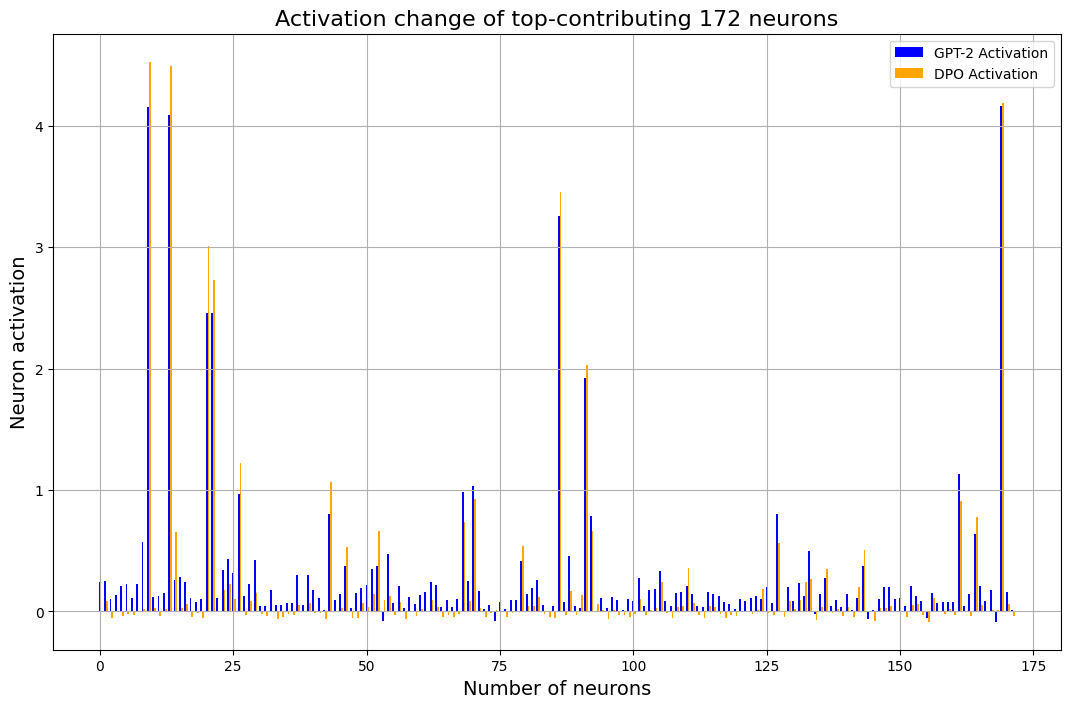

In [18]:
# Step 3: Plot the activations for GPT-2 and DPO for the top 172 rows
plt.figure(figsize=(13, 8))
index = np.arange(172)
bar_width = 0.35

plt.bar(index, ranked_df['gpt2_activation'], bar_width, label='GPT-2 Activation', color='blue')
plt.bar(index + bar_width, ranked_df['dpo_activation'], bar_width, label='DPO Activation', color='orange')

plt.title('Activation change of top-contributing 172 neurons', fontsize=16)
plt.xlabel('Number of neurons', fontsize=14)
plt.ylabel('Neuron activation', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

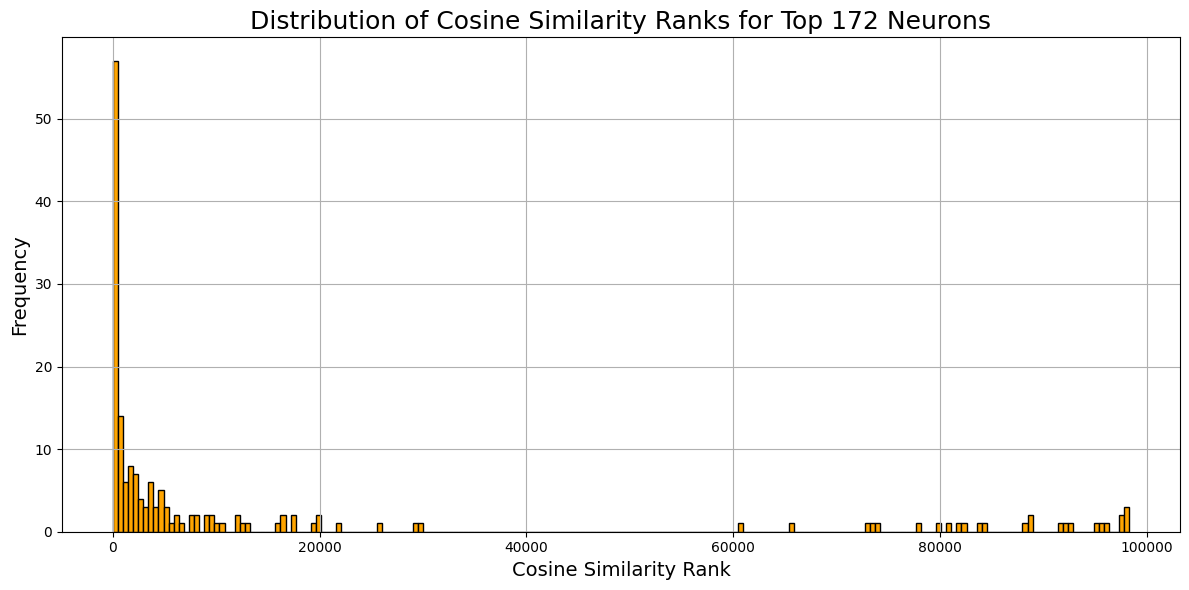

In [25]:
# Step 1: Plot the distribution of the cossim ranks of the 172 neurons
plt.figure(figsize=(12, 6))
plt.hist(ranked_df['cossim_rank'], bins=200, color='orange', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Cosine Similarity Ranks for Top 172 Neurons', fontsize=18)
plt.xlabel('Cosine Similarity Rank', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

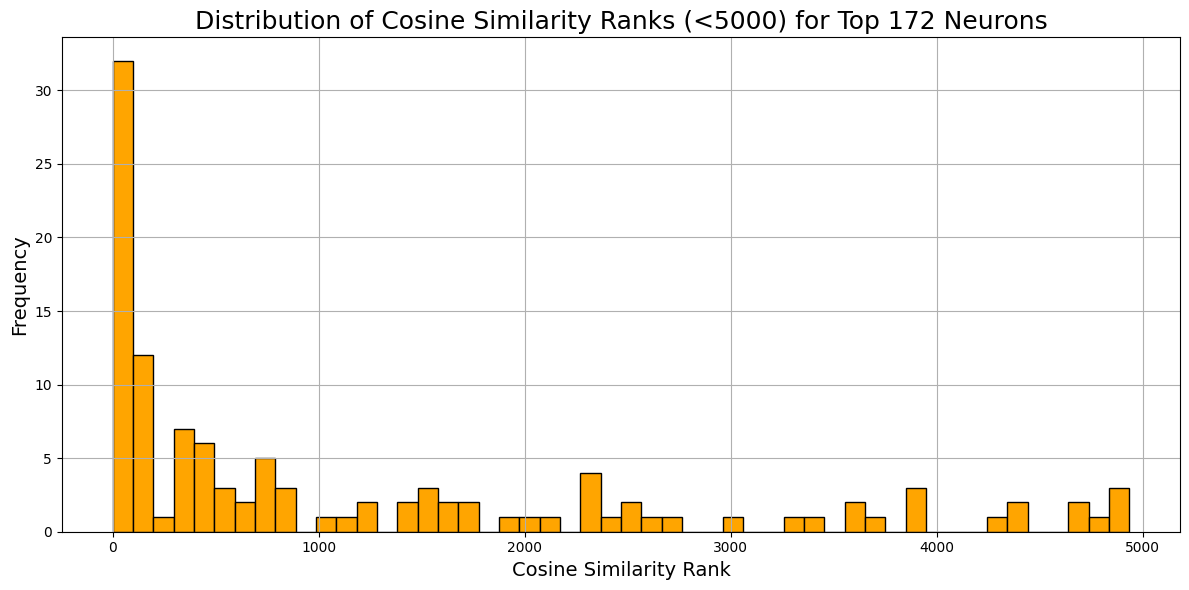

In [24]:
# Filter the ranked_df to include only rows with cossim_rank < 5000
filtered_df = ranked_df[ranked_df['cossim_rank'] < 5000]

# Step 1: Plot the distribution of the ranks smaller than 5000
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['cossim_rank'], bins=50, color='orange', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Cosine Similarity Ranks (<5000) for Top 172 Neurons', fontsize=18)
plt.xlabel('Cosine Similarity Rank', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
# Compute the projection reduction contributed by weakly toxic neurons and weakly non-toxic neurons

# Step 1: Filter rows with negative cosine similarity
negative_cossim_sum = ranked_df[ranked_df['cosine_similarity'] < 0]['projection_diff'].sum()

# Step 2: Filter rows with positive cosine similarity
positive_cossim_sum = ranked_df[ranked_df['cosine_similarity'] >= 0]['projection_diff'].sum()

# Output the results
print(f"Sum of projection difference for rows with negative cosine similarity: {negative_cossim_sum}")
print(f"Sum of projection difference for rows with positive cosine similarity: {positive_cossim_sum}")

Sum of projection difference for rows with negative cosine similarity: 1.0142449760645593
Sum of projection difference for rows with positive cosine similarity: 6.138313120052044


##### Four groups of neurons for toxicity reduction

In [17]:
# Define conditions for each group
conditions = {
    'Toxic neurons activated less positively': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] >= 0) & 
                              (merged_df['activation_diff'] > 0),
    
    'Toxic neurons activated more negatively': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] < 0) & 
                              (merged_df['activation_diff'] > 0),
    
    'Anti-toxic neurons activate more positively': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] >= 0) & 
                                  (merged_df['activation_diff'] < 0),
    
    'Anti-toxic neurons activated less negatively': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] < 0) & 
                                  (merged_df['activation_diff'] < 0)
}

# Initialize a dictionary to store the results
results = {}

# Loop through each condition, filter the DataFrame, and compute the required metrics
for group_name, condition in conditions.items():
    group_df = merged_df[condition]
    neuron_count = len(group_df)
    projection_diff_sum = group_df['projection_diff'].sum()
    
    # Compute the average projection difference per neuron
    avg_projection_diff = projection_diff_sum / neuron_count if neuron_count > 0 else 0
    
    results[group_name] = {
        'neuron_count': neuron_count,
        'projection_diff_sum': projection_diff_sum,
        'avg_projection_diff': avg_projection_diff
    }

# Display the results
for group_name, metrics in results.items():
    print(f"Group: {group_name}")
    print(f"  Number of Neurons: {metrics['neuron_count']}")
    print(f"  Sum of Projection Difference: {metrics['projection_diff_sum']}")
    print(f"  Average Projection Difference per Neuron: {metrics['avg_projection_diff']}")
    print()

Group: Toxic neurons activated less positively
  Number of Neurons: 3961
  Sum of Projection Difference: 15.110765946162987
  Average Projection Difference per Neuron: 0.003814886631194897

Group: Toxic neurons activated more negatively
  Number of Neurons: 17779
  Sum of Projection Difference: 11.335931471225972
  Average Projection Difference per Neuron: 0.0006376023100976417

Group: Anti-toxic neurons activate more positively
  Number of Neurons: 1803
  Sum of Projection Difference: 3.3198204796992603
  Average Projection Difference per Neuron: 0.0018412759177477871

Group: Anti-toxic neurons activated less negatively
  Number of Neurons: 25390
  Sum of Projection Difference: 17.71732605855467
  Average Projection Difference per Neuron: 0.000697807249253827



##### Four groups of neurons for toxicity increase

In [52]:
# Define conditions for each group
conditions = {
    'Toxic neurons activated more positively': (merged_df['gpt2_cossim'] > 0) & 
                                               (merged_df['gpt2_activation'] >= 0) & 
                                               (merged_df['activation_diff'] < 0),
    
    'Toxic neurons activated less negatively': (merged_df['gpt2_cossim'] > 0) & 
                                               (merged_df['gpt2_activation'] < 0) & 
                                               (merged_df['activation_diff'] < 0),
    
    'Anti-toxic neurons activate less positively': (merged_df['gpt2_cossim'] < 0) & 
                                                   (merged_df['gpt2_activation'] >= 0) & 
                                                   (merged_df['activation_diff'] > 0),
    
    'Anti-toxic neurons activated more negatively': (merged_df['gpt2_cossim'] < 0) & 
                                                    (merged_df['gpt2_activation'] < 0) & 
                                                    (merged_df['activation_diff'] > 0)
}

# Initialize a dictionary to store the results
results = {}

# Loop through each condition, filter the DataFrame, and compute the required metrics
for group_name, condition in conditions.items():
    group_df = merged_df[condition]
    neuron_count = len(group_df)
    projection_diff_sum = group_df['projection_diff'].sum()
    
    results[group_name] = {
        'neuron_count': neuron_count,
        'projection_diff_sum': projection_diff_sum
    }

# Display the results
for group_name, metrics in results.items():
    print(f"Group: {group_name}")
    print(f"  Number of Neurons: {metrics['neuron_count']}")
    print(f"  Sum of Projection Difference: {metrics['projection_diff_sum']}")
    print()

Group: Toxic neurons activated more positively
  Number of Neurons: 1809
  Sum of Projection Difference: -2.0542335793277626

Group: Toxic neurons activated less negatively
  Number of Neurons: 23985
  Sum of Projection Difference: -14.371892654188724

Group: Anti-toxic neurons activate less positively
  Number of Neurons: 4925
  Sum of Projection Difference: -14.633146468860748

Group: Anti-toxic neurons activated more negatively
  Number of Neurons: 18650
  Sum of Projection Difference: -9.208128297088422



##### Plot pie charts

In [18]:
# First set of conditions
conditions_set_1 = {
    'toxic_pos_act_pos_diff': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] >= 0) & 
                              (merged_df['activation_diff'] > 0),
    
    'toxic_neg_act_pos_diff': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] < 0) & 
                              (merged_df['activation_diff'] > 0),
    
    'antitoxic_pos_act_neg_diff': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] >= 0) & 
                                  (merged_df['activation_diff'] < 0),
    
    'antitoxic_neg_act_neg_diff': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] < 0) & 
                                  (merged_df['activation_diff'] < 0)
}

# Second set of conditions
conditions_set_2 = {
    'toxic_pos_act_neg_diff': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] >= 0) & 
                              (merged_df['activation_diff'] < 0),
    
    'toxic_neg_act_neg_diff': (merged_df['gpt2_cossim'] > 0) & 
                              (merged_df['gpt2_activation'] < 0) & 
                              (merged_df['activation_diff'] < 0),
    
    'antitoxic_pos_act_pos_diff': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] >= 0) & 
                                  (merged_df['activation_diff'] > 0),
    
    'antitoxic_neg_act_pos_diff': (merged_df['gpt2_cossim'] < 0) & 
                                  (merged_df['gpt2_activation'] < 0) & 
                                  (merged_df['activation_diff'] > 0)
}

# Initialize dictionaries to store the results from both sets of conditions
results_set_1 = {}
results_set_2 = {}

# Function to compute neuron count and projection diff sum
def compute_group_metrics(conditions, merged_df):
    results = {}
    for group_name, condition in conditions.items():
        group_df = merged_df[condition]
        neuron_count = len(group_df)
        projection_diff_sum = group_df['projection_diff'].sum()

        results[group_name] = {
            'neuron_count': neuron_count,
            'projection_diff_sum': projection_diff_sum
        }
    return results

In [19]:
# Compute results for both sets
results_set_1 = compute_group_metrics(conditions_set_1, merged_df)
results_set_2 = compute_group_metrics(conditions_set_2, merged_df)

In [20]:
# Define custom names for the pie chart segments
custom_names_set_1 = {
    'toxic_pos_act_pos_diff': 'Toxic neurons activated less positively',
    'toxic_neg_act_pos_diff': 'Toxic neurons activated more negatively',
    'antitoxic_pos_act_neg_diff': 'Anti-toxic neurons activate more positively',
    'antitoxic_neg_act_neg_diff': 'Anti-toxic neurons activated less negatively'
}

custom_names_set_2 = {
    'toxic_pos_act_neg_diff': 'Toxic neurons activated more positively',
    'toxic_neg_act_neg_diff': 'Toxic neurons activated less negatively',
    'antitoxic_pos_act_pos_diff': 'Anti-toxic neurons activate less positively',
    'antitoxic_neg_act_pos_diff': 'Anti-toxic neurons activated more negatively'
}

# Calculate total projection diff sums for each set
total_sum_set_1 = sum([metrics['projection_diff_sum'] for metrics in results_set_1.values()])
total_sum_set_2 = sum([metrics['projection_diff_sum'] for metrics in results_set_2.values()])

# Calculate the percentages
percentages_set_1 = {group_name: (metrics['projection_diff_sum'] / total_sum_set_1) * 100 
                     for group_name, metrics in results_set_1.items()}

percentages_set_2 = {group_name: (metrics['projection_diff_sum'] / total_sum_set_2) * 100 
                     for group_name, metrics in results_set_2.items()}

# Prepare labels with custom names, actual numbers, and percentages for Set 1
labels_set_1 = [f"{custom_names_set_1[group_name]}\n{metrics['projection_diff_sum']:.2f} ({percentages_set_1[group_name]:.1f}%)"
                for group_name, metrics in results_set_1.items()]

# Prepare labels with custom names, actual numbers, and percentages for Set 2
labels_set_2 = [f"{custom_names_set_2[group_name]}\n{metrics['projection_diff_sum']:.2f} ({percentages_set_2[group_name]:.1f}%)"
                for group_name, metrics in results_set_2.items()]

# Define a custom color scheme
colors_set_1 = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
colors_set_2 = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

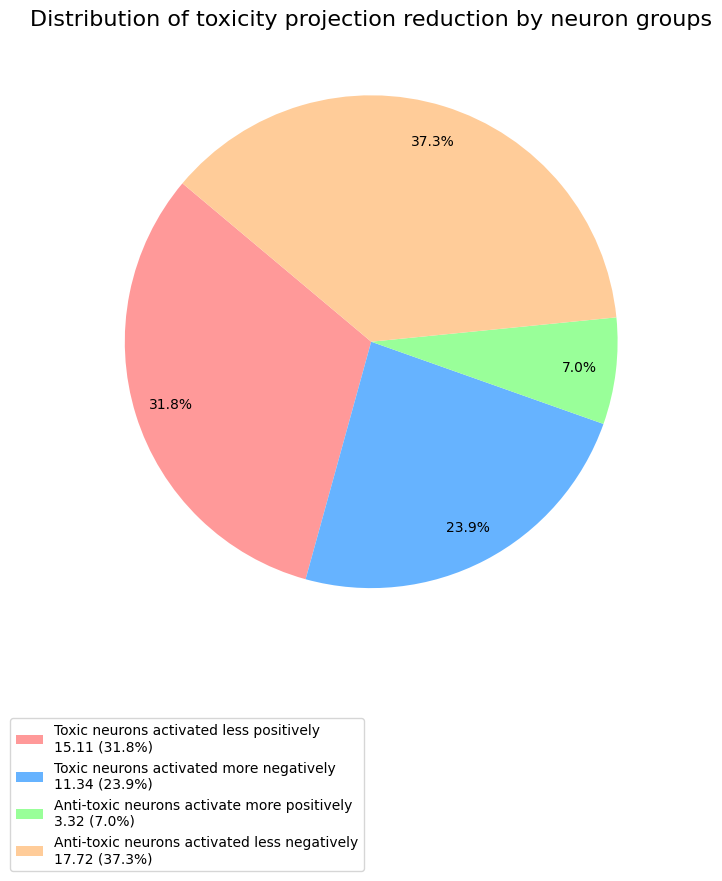

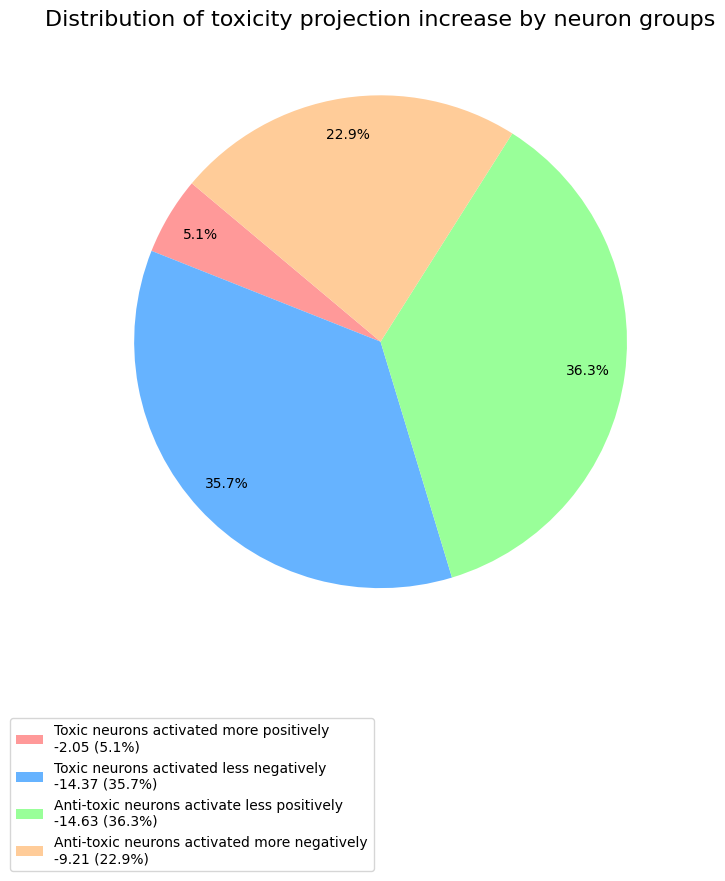

In [21]:
# Plot pie chart for Set 1
plt.figure(figsize=(8, 8))
plt.pie(
    percentages_set_1.values(),
    labels=None,  # Disable labels outside the pie
    colors=colors_set_1,
    startangle=140,
    autopct=lambda p: f'{p:.1f}%',  # Display percentage inside the pie slices
    pctdistance=0.85  # Position the percentage labels closer to the center
)
# Add a legend with custom labels
plt.legend(labels=labels_set_1, loc="best", bbox_to_anchor=(0.5, -0.1), fontsize=10)
plt.title('Distribution of toxicity projection reduction by neuron groups', fontsize=16)
plt.show()

# Plot pie chart for Set 2
plt.figure(figsize=(8, 8))
plt.pie(
    percentages_set_2.values(),
    labels=None,  # Disable labels outside the pie
    colors=colors_set_2,
    startangle=140,
    autopct=lambda p: f'{p:.1f}%',  # Display percentage inside the pie slices
    pctdistance=0.85  # Position the percentage labels closer to the center
)
# Add a legend with custom labels
plt.legend(labels=labels_set_2, loc="best", bbox_to_anchor=(0.5, -0.1), fontsize=10)
plt.title('Distribution of toxicity projection increase by neuron groups', fontsize=16)
plt.show()

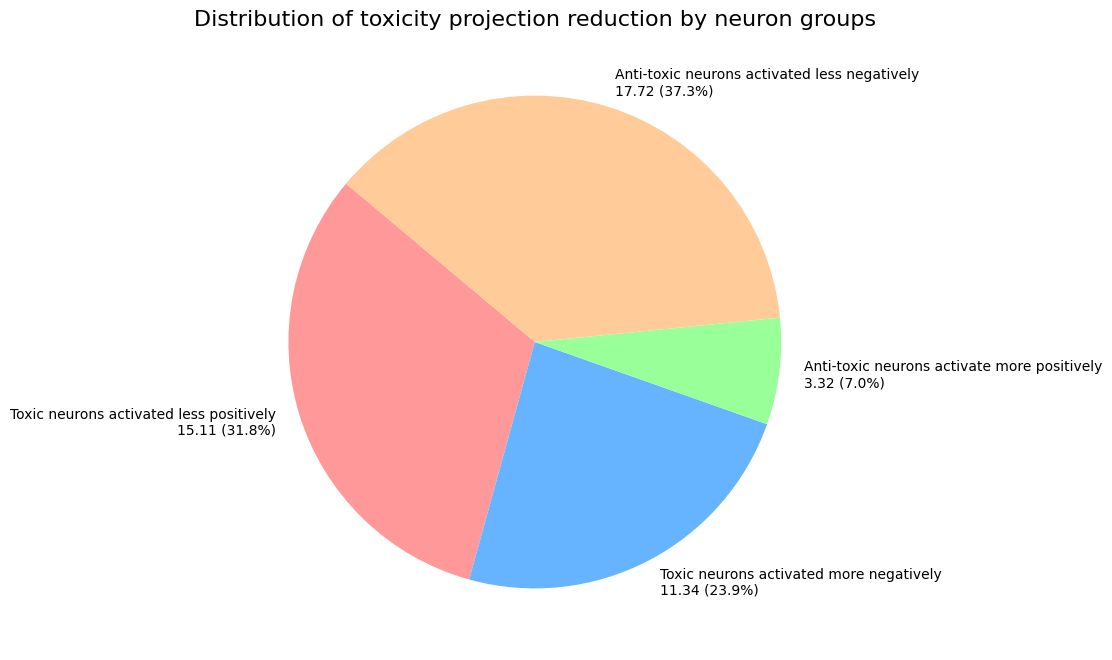

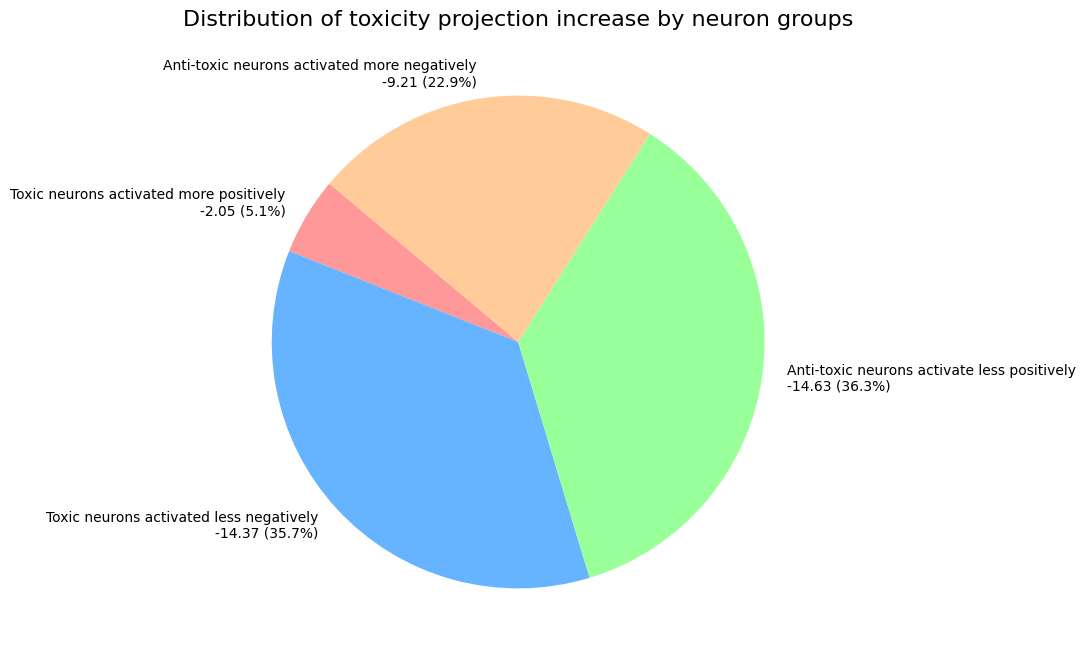

In [48]:
# Plot pie chart for Set 1
plt.figure(figsize=(8, 8))
plt.pie(percentages_set_1.values(), labels=labels_set_1, colors=colors_set_1, startangle=140)
plt.title('Distribution of toxicity projection reduction by neuron groups', fontsize=16)
plt.show()

# Plot pie chart for Set 2
plt.figure(figsize=(8, 8))
plt.pie(percentages_set_2.values(), labels=labels_set_2, colors=colors_set_2, startangle=140)
plt.title('Distribution of toxicity projection increase by neuron groups', fontsize=16)
plt.show()

In [13]:
# Function to plot the distribution for a given set
def plot_group_distribution(group_name, projection_diff_sum, percentage, custom_name, color, set_name):
    plt.figure(figsize=(6, 4))
    plt.barh([custom_name], [projection_diff_sum], color=color)
    plt.title(f"Distribution of {custom_name} ({set_name})", fontsize=16)
    plt.xlabel('Sum of Projection Diff', fontsize=14)
    plt.ylabel('Neuron Group', fontsize=14)
    for i, v in enumerate([projection_diff_sum]):
        plt.text(v + 0.02 * max(projection_diff_sum, 0.02), i, f"{v:.2f} ({percentage:.1f}%)", color='black', va='center', fontsize=12)
    plt.show()

In [15]:
# Plot distribution for each group in Set 1
for group_name in results_set_1:
    metrics = results_set_1[group_name]
    percentage = percentages_set_1[group_name]
    custom_name = custom_names_set_1[group_name]
    color = colors_set_1[list(results_set_1.keys()).index(group_name)]
    
    plot_group_distribution(group_name, metrics['projection_diff_sum'], percentage, custom_name, color, 'Set 1')

# Plot distribution for each group in Set 2
for group_name in results_set_2:
    metrics = results_set_2[group_name]
    percentage = percentages_set_2[group_name]
    custom_name = custom_names_set_2[group_name]
    color = colors_set_2[list(results_set_2.keys()).index(group_name)]
    
    plot_group_distribution(group_name, metrics['projection_diff_sum'], percentage, custom_name, color, 'Set 2')

IndexError: list index out of range

In [59]:
# Combine the results for plotting
combined_results = {
    'Toxic neurons, Initially positively activated': [results_set_1['toxic_pos_act_pos_diff']['projection_diff_sum'], 
                           results_set_2['toxic_pos_act_neg_diff']['projection_diff_sum']],
    
    'Toxic neurons, Initially negatively activated': [results_set_1['toxic_neg_act_pos_diff']['projection_diff_sum'], 
                           results_set_2['toxic_neg_act_neg_diff']['projection_diff_sum']],
    
    'Anti-toxic neurons, Initially positively activated': [results_set_1['antitoxic_pos_act_neg_diff']['projection_diff_sum'], 
                               results_set_2['antitoxic_pos_act_pos_diff']['projection_diff_sum']],
    
    'Anti-toxic neurons, Initially negatively activated': [results_set_1['antitoxic_neg_act_neg_diff']['projection_diff_sum'], 
                               results_set_2['antitoxic_neg_act_pos_diff']['projection_diff_sum']]
}

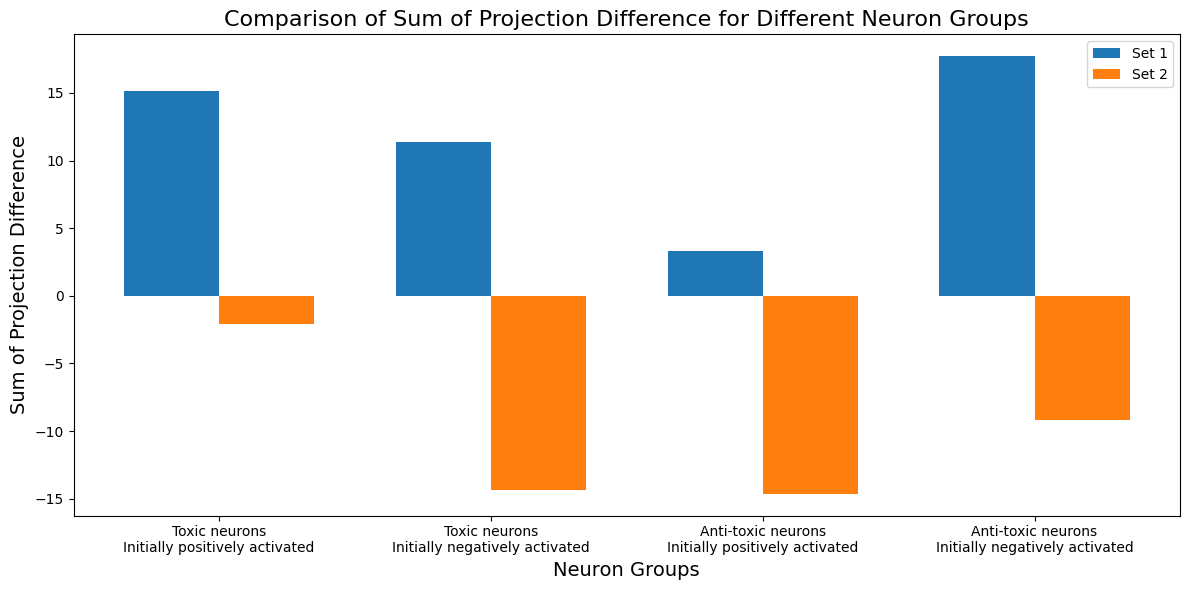

In [60]:
# Plotting the results
categories = list(combined_results.keys())
set_1_values = [combined_results[cat][0] for cat in categories]
set_2_values = [combined_results[cat][1] for cat in categories]

# Modify the category labels to split each at the comma, putting the second part on a new line
formatted_categories = [label.replace(', ', '\n') for label in categories]

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot bars for each set
bars1 = plt.bar(index, set_1_values, bar_width, label='Set 1')
bars2 = plt.bar(index + bar_width, set_2_values, bar_width, label='Set 2')

# Adding the title and labels
plt.xlabel('Neuron Groups', fontsize=14)
plt.ylabel('Sum of Projection Difference', fontsize=14)
plt.title('Comparison of Sum of Projection Difference for Different Neuron Groups', fontsize=16)

# Adding the category labels, with each label split onto two lines
plt.xticks(index + bar_width / 2, formatted_categories, rotation=0, ha='center')

# Adding the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()